In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import holidays
import optuna

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('../urbanbus_data/SER_0b91_start_aggregated.csv')

df = df.groupby(["Ride_start_datetime", "Bus_Service_Number", "Direction"], as_index=False)["Passenger_Count"].sum()
df['Ride_start_datetime'] = pd.to_datetime(df['Ride_start_datetime'], errors='coerce')
df = df.sort_values('Ride_start_datetime').reset_index(drop=True)

print(f"Total records after aggregation: {len(df):,}")
print(f"Date range: {df['Ride_start_datetime'].min()} to {df['Ride_start_datetime'].max()}\n")
df.head()

Total records after aggregation: 13,572
Date range: 2017-10-01 00:00:00 to 2018-03-31 23:45:00



,Ride_start_datetime,Bus_Service_Number,Direction,Passenger_Count
0,2017-10-01 00:00:00,SER_0b91,Start,2
1,2017-10-01 00:15:00,SER_0b91,Start,1
2,2017-10-01 05:45:00,SER_0b91,Start,21
3,2017-10-01 06:00:00,SER_0b91,Start,37
4,2017-10-01 06:15:00,SER_0b91,Start,48


In [4]:
# Check for stationarity

result = adfuller(df['Passenger_Count'])

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print("Time series is STATIONARY")
else:
    print("Time series in NON-STATIONARY")

ADF Statistic: -15.895695207514
p-value: 8.440832249183706e-29
Time series is STATIONARY


<Figure size 1000x500 with 0 Axes>

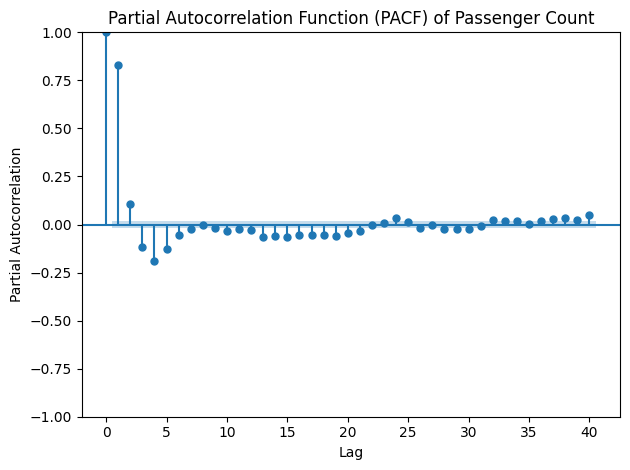

In [5]:
ts = df['Passenger_Count'].dropna()

# PACF plot
plt.figure(figsize=(10, 5))
plot_pacf(ts, lags=40, method='ywm')
plt.title('Partial Autocorrelation Function (PACF) of Passenger Count')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.tight_layout()
plt.show()

In [6]:
# Datetime features
df['hour'] = df['Ride_start_datetime'].dt.hour
df['minute'] = df['Ride_start_datetime'].dt.minute
df['day'] = df['Ride_start_datetime'].dt.day
df['dayofweek'] = df['Ride_start_datetime'].dt.dayofweek
df['month'] = df['Ride_start_datetime'].dt.month
df['year'] = df['Ride_start_datetime'].dt.year
df['week_of_year'] = df['Ride_start_datetime'].dt.isocalendar().week

# Cyclic encoding
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)
df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Weekend and holiday flag
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
china_holidays = holidays.country_holidays('CN')
df['is_holiday'] = df['Ride_start_datetime'].dt.date.isin(china_holidays).astype(int)

# Peak hour flag
peak_hours = df.groupby('hour')['Passenger_Count'].sum().nlargest(2).index.tolist()
df['is_peak_hour'] = df['hour'].isin(peak_hours).astype(int)

df = df.sort_values('Ride_start_datetime').reset_index(drop=True)

# Lag and window features
for lag in [1, 2, 3, 4, 8, 12, 24]:
    df[f'lag_{lag}'] = df['Passenger_Count'].shift(lag)

for window in [4, 8, 12, 24]:
    shifted_data = df['Passenger_Count'].shift(1)
    df[f'rolling_mean_{window}'] = shifted_data.rolling(window=window, min_periods=1).mean()
    df[f'rolling_std_{window}'] = shifted_data.rolling(window=window, min_periods=1).std()

# Drop rows with NaNs created by the lag/rolling features
lag_roll_cols = [col for col in df.columns if col.startswith(('lag_', 'rolling_'))]
df = df.dropna(subset=lag_roll_cols).reset_index(drop=True)
df = df.fillna(0)

In [7]:
max_date = df['Ride_start_datetime'].max()
cutoff_date = max_date - timedelta(days=28)

train_df = df[df['Ride_start_datetime'] < cutoff_date].copy()
val_df = df[df['Ride_start_datetime'] >= cutoff_date].copy()

print(f"\nTraining Set: {len(train_df):,} records ({train_df['Ride_start_datetime'].min()} to {train_df['Ride_start_datetime'].max()})")
print(f"Validation Set: {len(val_df):,} records ({val_df['Ride_start_datetime'].min()} to {val_df['Ride_start_datetime'].max()})")


Training Set: 11,452 records (2017-10-01 11:15:00 to 2018-03-03 23:30:00)
Validation Set: 2,096 records (2018-03-03 23:45:00 to 2018-03-31 23:45:00)


In [8]:
cat_cols = ['Bus_Service_Number', 'Direction']
num_cols = [
    'hour', 'minute', 'day', 'dayofweek', 'month', 'year', 'week_of_year',
    'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'dow_sin', 'dow_cos',
    'month_sin', 'month_cos', 'is_weekend', 'is_holiday', 'is_peak_hour'
]
lag_roll_cols = [col for col in train_df.columns if col.startswith(('lag_', 'rolling_'))]
features = num_cols + lag_roll_cols

X_train = train_df[features].copy()
y_train = train_df['Passenger_Count'].copy()
X_val = val_df[features].copy()
y_val = val_df['Passenger_Count'].copy()

print(f"\nFeature matrices prepared:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val: {X_val.shape}")


Feature matrices prepared:
  X_train: (11452, 33)
  X_val: (2096, 33)


In [9]:
# Helper functions
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if np.sum(mask) == 0:
        return 0.0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = np.abs(y_true) + np.abs(y_pred)
    mask = denom != 0
    if np.sum(mask) == 0:
        return 0.0
    return np.mean(2.0 * np.abs(y_true[mask] - y_pred[mask]) / denom[mask]) * 100

def evaluate_model(y_true, y_pred, set_name="Set"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_true, y_pred)
    print(f"\n{set_name} Performance:")
    print(f"  MAE:   {mae:.4f}")
    print(f"  RMSE:  {rmse:.4f}")
    print(f"  R²:    {r2:.4f}")
    print(f"  MAPE:  {mape:.2f}%")
    print(f"  sMAPE: {smape:.2f}%")
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape, 'sMAPE': smape}


# Optuna objective functions
def objective(trial, model_type, X_train, y_train, X_val, y_val):
    if model_type == "catboost":
        params = {
            "iterations": trial.suggest_int("iterations", 100, 1000),
            "depth": trial.suggest_int("depth", 4, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
            "random_seed": 42,
            "verbose": 0
        }
        model = CatBoostRegressor(**params)

    elif model_type == "xgboost":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "max_depth": trial.suggest_int("max_depth", 3, 8),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "gamma": trial.suggest_float("gamma", 1.0, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 2.0, 20.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.5, 10.0, log=True),
            "random_state": 42,
            "n_jobs": -1
        }
        model = XGBRegressor(**params)

    elif model_type == "lightgbm":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "num_leaves": trial.suggest_int("num_leaves", 10, 30),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "random_state": 42
        }
        model = LGBMRegressor(**params)

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_val)
    return mean_absolute_error(y_val, preds) 


# Tuning functions
def tune_model(model_type, X_train, y_train, X_val, y_val, n_trials=25):
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, model_type, X_train, y_train, X_val, y_val), n_trials=n_trials)
    print(f"\n✅ Best params for {model_type}: {study.best_params}")
    return study.best_params


def train_with_optuna(model_type, X_train, y_train, X_val, y_val, best_params):
    if model_type == "catboost":
        model = CatBoostRegressor(**best_params, random_seed=42, verbose=0)
    elif model_type == "xgboost":
        model = XGBRegressor(**best_params, random_state=42)
    elif model_type == "lightgbm":
        model = LGBMRegressor(**best_params, random_state=42)

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    y_pred_train = pipe.predict(X_train)
    y_pred_val = pipe.predict(X_val)

    print("\nTraining Set:")
    train_metrics = evaluate_model(y_train, y_pred_train, "Train")
    print("\nValidation Set:")
    validation_metrics = evaluate_model(y_val, y_pred_val, "Validation")

    return pipe, train_metrics, validation_metrics


In [10]:
def plot_forecasts(y_true, y_pred, time_index, set_name="Validation Set", sample_days=7):
    results_df = pd.DataFrame({
        'Ride_start_datetime': time_index,
        'Actual': y_true,
        'Predicted': y_pred
    }).set_index('Ride_start_datetime')

    # Forecast vs. Actuals over Time
    sample_end_date = results_df.index.min() + pd.Timedelta(days=sample_days)
    results_sample_df = results_df[results_df.index <= sample_end_date]

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(2, 1, figsize=(18, 12))
    
    # Time series plot
    sns.lineplot(data=results_sample_df, x=results_sample_df.index, y='Actual', ax=axes[0], label='Actual', color='blue', linewidth=1.5)
    sns.lineplot(data=results_sample_df, x=results_sample_df.index, y='Predicted', ax=axes[0], label='Predicted', color='red', alpha=0.8, linestyle='--')
    axes[0].set_title(f'Forecast vs. Actuals ({set_name} - First {sample_days} Days)', fontsize=16)
    axes[0].set_xlabel('Datetime', fontsize=12)
    axes[0].set_ylabel('Passenger Count', fontsize=12)
    axes[0].legend()
    axes[0].tick_params(axis='x', rotation=45)

    # Scatter Plot of Predicted vs. Actual
    max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
    sns.scatterplot(data=results_df, x='Actual', y='Predicted', ax=axes[1], alpha=0.5, s=50)
    axes[1].plot([0, max_val], [0, max_val], color='black', linestyle='--', lw=2, label='Perfect Forecast')
    axes[1].set_title('Predicted vs. Actual Values', fontsize=16)
    axes[1].set_xlabel('Actual Passenger Count', fontsize=12)
    axes[1].set_ylabel('Predicted Passenger Count', fontsize=12)
    axes[1].set_aspect('equal', adjustable='box')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

[I 2025-10-22 17:15:51,641] A new study created in memory with name: no-name-03754522-ba4a-411c-8d5f-5b0b5973d2f3
[I 2025-10-22 17:15:52,458] Trial 0 finished with value: 12.315375328063965 and parameters: {'n_estimators': 304, 'max_depth': 5, 'learning_rate': 0.02684455097569316, 'subsample': 0.7933517865540722, 'colsample_bytree': 0.5233707982116975, 'gamma': 1.7330342962008252, 'reg_lambda': 10.650288977412758, 'reg_alpha': 2.472857154781055}. Best is trial 0 with value: 12.315375328063965.
[I 2025-10-22 17:15:53,691] Trial 1 finished with value: 12.50042724609375 and parameters: {'n_estimators': 496, 'max_depth': 5, 'learning_rate': 0.06216862479089021, 'subsample': 0.6995228676672804, 'colsample_bytree': 0.5970208635094838, 'gamma': 2.4398744824949135, 'reg_lambda': 3.1482551223281328, 'reg_alpha': 2.0385365542913156}. Best is trial 0 with value: 12.315375328063965.
[I 2025-10-22 17:15:54,898] Trial 2 finished with value: 12.4221830368042 and parameters: {'n_estimators': 358, 'max


✅ Best params for xgboost: {'n_estimators': 409, 'max_depth': 7, 'learning_rate': 0.01788371346645269, 'subsample': 0.7519772204176384, 'colsample_bytree': 0.6805908757368064, 'gamma': 3.2942439876013734, 'reg_lambda': 11.969926599784005, 'reg_alpha': 1.1883325927534312}

Training Set:

Train Performance:
  MAE:   9.7286
  RMSE:  12.7436
  R²:    0.8946
  MAPE:  19.80%
  sMAPE: 17.19%

Validation Set:

Validation Performance:
  MAE:   12.1616
  RMSE:  16.2990
  R²:    0.8517
  MAPE:  25.27%
  sMAPE: 20.58%


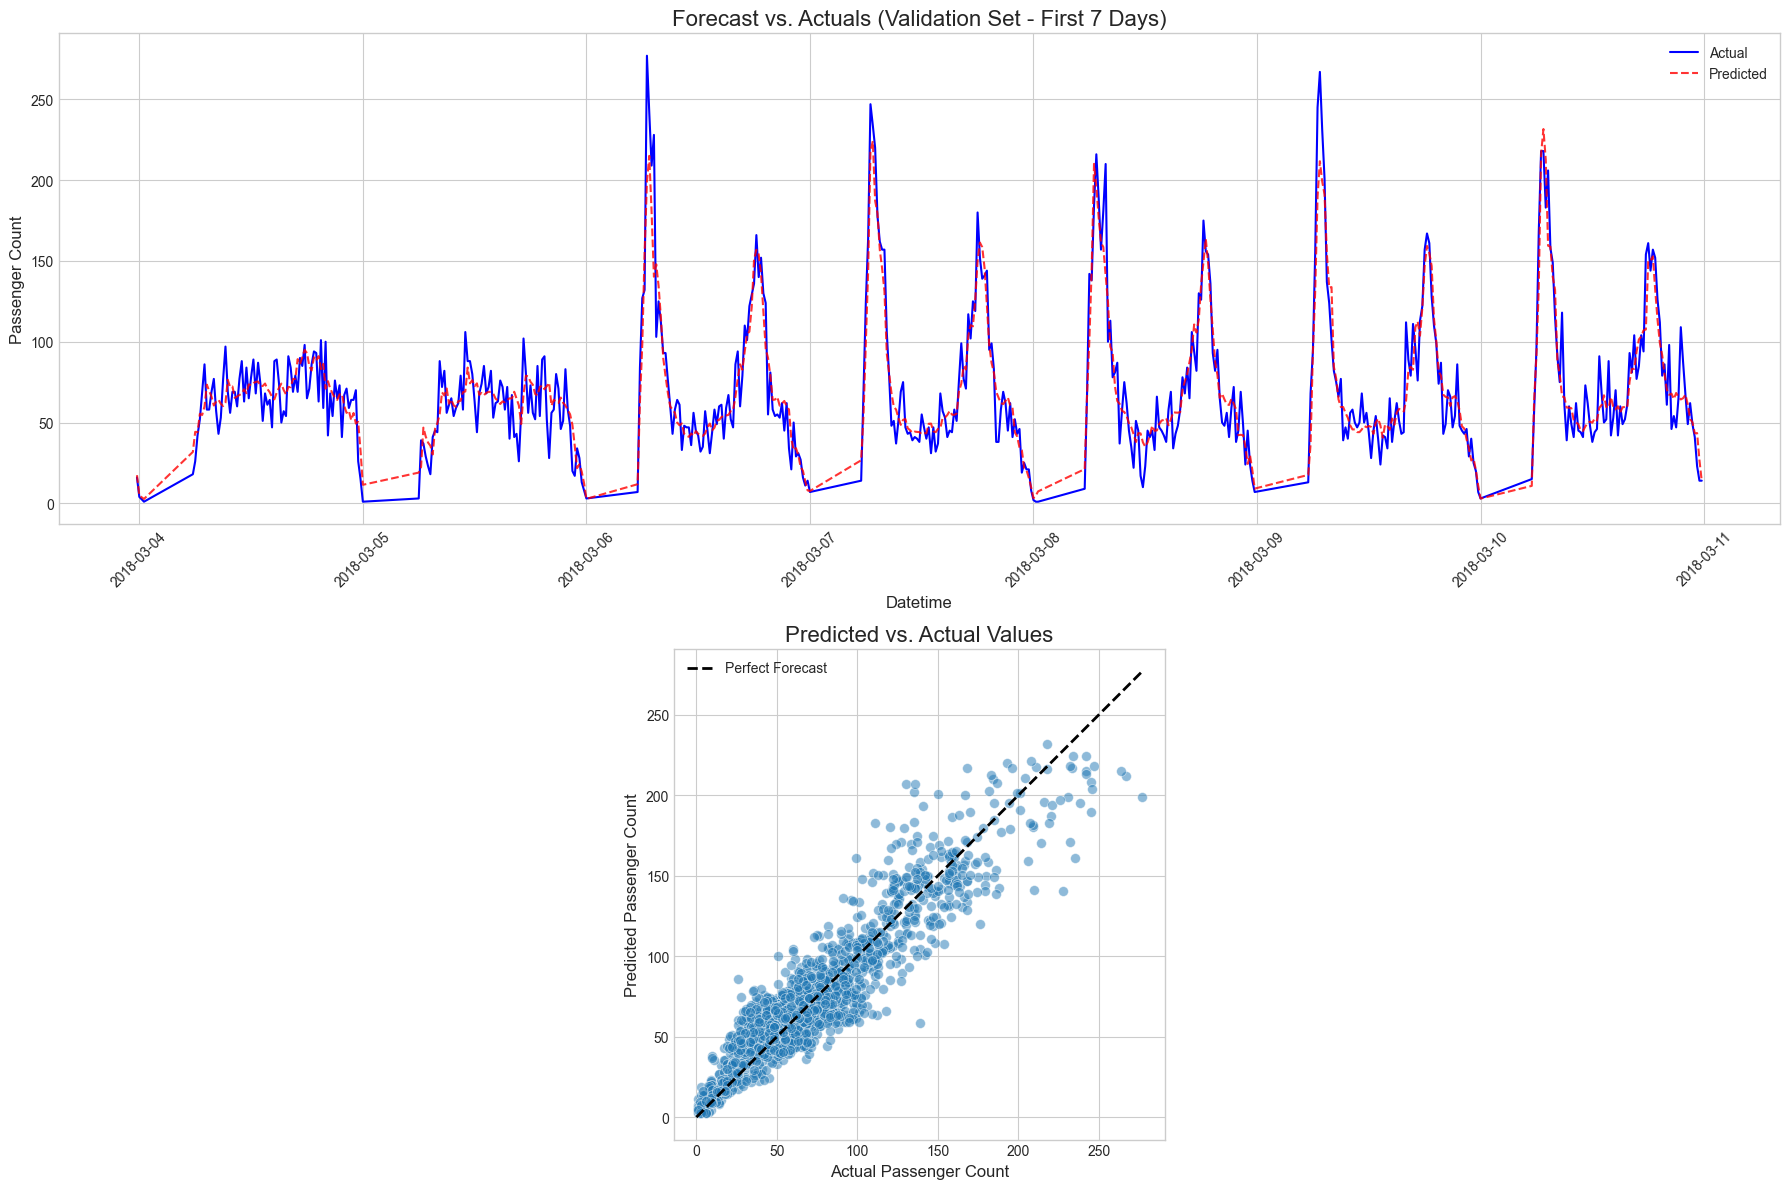

In [11]:
best_params_xgb = tune_model("xgboost", X_train, y_train, X_val, y_val, n_trials=30)
model_pipe_xgb, train_metrics, test_metrics = train_with_optuna("xgboost", X_train, y_train, X_val, y_val, best_params_xgb)

y_pred_val = model_pipe_xgb.predict(X_val)
plot_forecasts(y_val, y_pred_val, val_df['Ride_start_datetime'])

In [12]:
# best_params_lgbm = tune_model("lightgbm", X_train, y_train, X_val, y_val, n_trials=30)
# model_pipe_lgbm, train_metrics, test_metrics = train_with_optuna("lightgbm", X_train, y_train, X_val, y_val, best_params_lgbm)

# y_pred_val = model_pipe_lgbm.predict(X_val)
# plot_forecasts(y_val, y_pred_val, val_df['Ride_start_datetime'])

In [13]:
# best_params_cb = tune_model("catboost", X_train, y_train, X_val, y_val, n_trials=15)
# model_pipe_cb, train_metrics, test_metrics = train_with_optuna("catboost", X_train, y_train, X_val, y_val, best_params_cb)

# y_pred_val = model_pipe_cb.predict(X_val)
# plot_forecasts(y_val, y_pred_val, val_df['Ride_start_datetime'])